In [1]:
## Library Import

# Basic
import re
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

# AutoML optuna library
import optuna
import optuna.integration.lightgbm as lgb

# Linear Model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Tree Model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metric
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

## for PCA
from sklearn.decomposition import PCA

# for VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# data load
df = pd.read_csv('original_full_data_20200319.csv', index_col = 0)
mmdf = pd.read_csv('bloomberg_map_index_20200319.csv', index_col = 0)

In [3]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = ((self.df[target_column] / self.df[target_column].shift(periods = self.target_day, axis = 0))-1).shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = (self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0))-1 # 여기에 1을 뺀걸 추가하면 되는거아닌가? 1.얼만에서 1이 빠진거니까

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [4]:
len(df.columns)

429

In [5]:
# date preprocessing

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [6]:
# fillna cubic -> ffill -> bfill

df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [7]:
# check na value

df.isna().sum().sum()

0

In [8]:
# class load

cla = Builder(df, mmdf, 260)

In [9]:
# execution function
# 새로운 데이터프레임 생성 
cla.execution()

,SPXIndex,MSRUITIndex,MSRUMATIndex,MXWO0ITIndex,MXWO0MTIndex,MXUS0ITIndex,MXEF0ITIndex,MXEF0MTIndex,CL1Comdty,LMAHDS03Comdty,LMCADS03Comdty,XAUCurncy,LMNIDS03Comdty,CCMPIndex,NKYIndex,CINDIndex,IXKIndex,XCIIndex,SOXIndex,MSERIndex,NMDPIndex,SZCOMPIndex,KOSPIIndex,FDTRIndex,GDPCQOQIndex,...,AMD_product,APPLE_product,AppliedMaterials_product,Aspeed_product,Dell_product,Facebook_product,Google_product,HPE_product,Intel_product,LamResearch_product,MediaTek_product,Micron_product,Microsoft_product,Nuvoton_product,Nvidia_product,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-01-02,1268.80000,76.343000,176.382000,78.490000,180.120000,76.360000,208.160000,319.120000,63.140000,2283.000000,4440.000000,516.880000,13900.000000,2243.740000,16361.54000,1881.68000,1017.970000,743.140000,493.130000,1058.800000,796.070000,283.482000,1389.270000,4.25000,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,1268.80000,77.777000,181.247000,80.040000,183.850000,76.360000,212.560000,327.930000,63.140000,2283.000000,4440.000000,534.150000,13900.000000,2243.740000,16361.54000,1881.68000,1017.970000,743.140000,493.130000,1062.560000,804.200000,283.482000,1394.870000,4.25000,5.4,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,1273.46000,79.620000,183.902000,81.090000,186.880000,77.210000,218.310000,334.380000,63.420000,2305.000000,4540.000000,534.400000,14100.000000,2263.460000,16361.54000,1893.19000,1026.090000,749.780000,496.690000,1073.470000,814.320000,283.482000,1402.110000,4.25000,5.4,...,0.682030,0.771197,1.026287,1.000000,1.000000,1.000000,1.223552,1.000000,0.829714,0.967572,1.000000,1.380558,0.743634,1.000000,1.109161,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,1273.48000,80.513000,181.900000,81.930000,186.060000,77.850000,219.810000,334.160000,62.790000,2300.000000,4512.000000,524.800000,14300.000000,2276.870000,16425.37000,1898.60000,1036.530000,755.590000,508.540000,1072.550000,817.080000,289.128000,1395.510000,4.25000,5.4,...,1.264163,0.718678,1.094089,1.000000,1.000000,1.000000,0.710449,1.000000,1.204864,0.824310,1.000000,0.901202,0.836536,1.000000,1.294707,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,1285.45000,81.507000,184.096000,83.360000,188.200000,79.190000,220.160000,337.090000,64.210000,2308.000000,4514.000000,539.950000,14325.000000,2305.620000,16428.21000,1921.27000,1052.340000,766.640000,519.570000,1077.530000,823.000000,291.290000,1412.780000,4.25000,5.4,...,0.966656,1.606885,1.514631,1.000000,1.000000,1.000000,1.685084,1.000000,0.833842,1.282477,1.000000,0.947752,2.059981,1.000000,0.980556,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,3039.88927,111.870172,251.525065,285.494806,256.858145,337.684544,534.027669,332.996622,56.261584,1729.421419,5917.243089,1498.030016,16550.815509,8337.710069,22792.10702,6524.36472,5353.354406,3419.358626,1681.440951,1208.383699,3308.756773,1660.471423,2091.024479,1.97455,2.0,...,0.900501,1.010875,1.764097,0.820641,0.808665,1.410060,1.415943,0.954658,0.776571,2.092578,0.829932,1.022473,1.347411,1.486079,0.898487,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,3039.42000,112.139000,251.912000,284.840800,257.400000,336.570000,536.4

In [10]:
df['KRXsemiconductor_close']

date
2006-01-02    0.105210
2006-01-03    0.078638
2006-01-04    0.074089
2006-01-05    0.062994
2006-01-06    0.033269
                ...   
2019-10-27         NaN
2019-10-28         NaN
2019-10-29         NaN
2019-10-30         NaN
2019-10-31         NaN
Name: KRXsemiconductor_close, Length: 5051, dtype: float64

In [11]:
df = df[:4791]

In [12]:
df = df[260:]

In [13]:
df['KRXsemiconductor_close']

date
2006-09-19    0.146139
2006-09-20    0.167541
2006-09-21    0.201915
2006-09-22    0.253597
2006-09-23    0.278472
                ...   
2019-02-09    0.152598
2019-02-10    0.152275
2019-02-11    0.137702
2019-02-12    0.098332
2019-02-13    0.082706
Name: KRXsemiconductor_close, Length: 4531, dtype: float64

In [14]:
len(df)

4531

In [15]:
# fill na for shifted data

df = df.fillna(method = 'ffill').fillna(method = 'bfill')

In [16]:
# check na

df.isna().sum().sum()

0

In [17]:
# features

len(df.columns)

1282

In [18]:
df.reset_index(inplace = True)

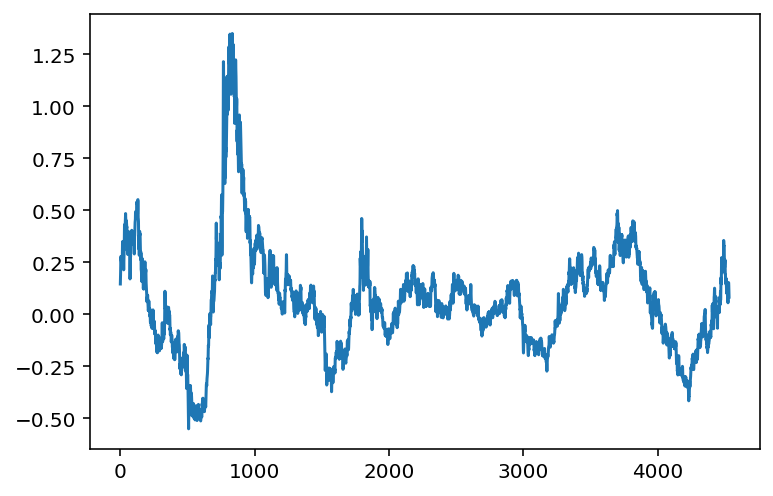

In [19]:
df['KRXsemiconductor_close'].plot()

In [20]:
df_back = df.copy()

In [22]:
date = df.date

In [23]:
# extract target
y_target = df['KRXsemiconductor_close']

In [24]:
df.drop(['date', 'KRXsemiconductor_close', 'SamsungElectronics_product', 'KRXsemiconductor_change', 'KRXsemiconductor_volume'], axis = True, inplace = True)

In [25]:
# scaling 하기전에 columns 뽑기 
col_name = df.columns

In [26]:
# scaling과 동시에 변환
#df = PowerTransformer().fit_transform(df)
df = StandardScaler().fit_transform(df)
#df = df.apply(lambda x : np.log1p(x))
#df = MinMaxScaler().fit_transfrom(df)

In [27]:
# scaling하면 colname사라지므로 다시 생성
df = pd.DataFrame(df, columns = col_name)

In [28]:
len(df.columns)

1278

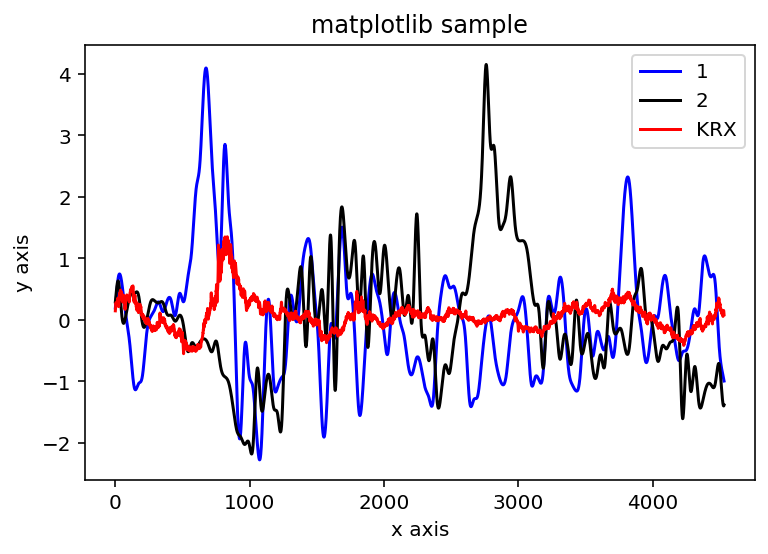

In [78]:
plt.plot(df['KOEXPTIIndex120'].values,'blue',label='1')
plt.plot(df['KOEAPYIndex'].values,'black',label='2')
plt.plot(y_target, 'r',label='KRX')
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.title('matplotlib sample')
plt.legend(loc='upper right')
plt.show()

In [42]:
df.isna().sum().sum()

0

In [31]:
# extract X_data
X_data = df.copy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [32]:
## Feature Selection Code
# Forward stepwise feature selection
# linear model 기준으로 유효 feature 뽑기. 돌리지 않아도 되는 코드

np.random.seed(0)

feature_name = list(X_train.columns)
feature_selected = []
score = []

for i in range(X_train.shape[1]):
    score_temp_list = np.zeros(len(feature_name))
    for j in range(len(feature_name)):
        temp = feature_selected.copy() 
        temp.append(feature_name[j])
        x_temp = X_train[temp]
        lr_temp = LinearRegression() 
        lr_temp.fit(x_temp, y_train)
        predict_temp = lr_temp.predict(X_test[temp])
        r2_temp = r2_score(y_test, predict_temp)
        score_temp = r2_temp
        score_temp_list[j] = score_temp 
        
    temp = feature_name[score_temp_list.argmax()]
    feature_selected.append(temp)
    feature_name.remove(temp)
    score.append(score_temp_list.max())
    print("%02d Selected: "%i, feature_selected)
    print("%02d Score : "%i, np.round(10000*np.array(score))/10000)
        
# finally selected features
feature_selected_final = feature_selected[:(np.array(score).argmax() + 1)]

00 Selected:  ['MSRUMATIndex']
00 Score :  [0.6296]
01 Selected:  ['MSRUMATIndex', 'EOKOS002Index260']
01 Score :  [0.6296 0.8111]
02 Selected:  ['MSRUMATIndex', 'EOKOS002Index260', 'MAPMINDXIndex']
02 Score :  [0.6296 0.8111 0.8499]
03 Selected:  ['MSRUMATIndex', 'EOKOS002Index260', 'MAPMINDXIndex', 'KOEXPTIIndex120']
03 Score :  [0.6296 0.8111 0.8499 0.8763]
04 Selected:  ['MSRUMATIndex', 'EOKOS002Index260', 'MAPMINDXIndex', 'KOEXPTIIndex120', 'KOVMPRODIndex120']
04 Score :  [0.6296 0.8111 0.8499 0.8763 0.894 ]
05 Selected:  ['MSRUMATIndex', 'EOKOS002Index260', 'MAPMINDXIndex', 'KOEXPTIIndex120', 'KOVMPRODIndex120', 'KOEAPYIndex']
05 Score :  [0.6296 0.8111 0.8499 0.8763 0.894  0.9093]
06 Selected:  ['MSRUMATIndex', 'EOKOS002Index260', 'MAPMINDXIndex', 'KOEXPTIIndex120', 'KOVMPRODIndex120', 'KOEAPYIndex', 'KOBONTLIndex120']
06 Score :  [0.6296 0.8111 0.8499 0.8763 0.894  0.9093 0.9191]
07 Selected:  ['MSRUMATIndex', 'EOKOS002Index260', 'MAPMINDXIndex', 'KOEXPTIIndex120', 'KOVMPRODInd

KeyboardInterrupt: 

# 변수 추출 완료

In [34]:
df['KRXsemiconductor_close'] = y_target

In [35]:
a, b = dmatrices('KRXsemiconductor_close ~ MSRUMATIndex+ EOKOS002Index260+ MAPMINDXIndex+ KOEXPTIIndex120+ KOVMPRODIndex120+ KOEAPYIndex+ KOBONTLIndex120+ LEIACEIndex1+ SKLILAIIndex260+ KOGFBALIndex60+ KOBPTBIndex5+ SKBSICSAIndex1+ FRNTTOTLIndex+ LEILCIIndex5+ FRNTTOTLIndex1+ MSRUMATIndex5+ KOSPIIndex5+ EMPRGBCIIndex60+ SAARTOTLIndex20+ PITLCHNGIndex+ USTBEXPIndex1+ SKLILCIndex260+ LEIAVGWIndex1+ KOBONTLIndex60+ CICRTOTIndex60+ LEIACEIndex5+ SKLICONEIndex260+ LMNIDS03Comdty60+ KOVMEXPSIndex120+ KOWDRIndex1+ SKhynix_change+ IXKIndex5+ Micron_change+ LEIMNOIndex1+ CICRTOTIndex5+ KOBPCAIndex20+ KOVMTOTSIndex120+ EMPRGBCIIndex20+ MXWO0MTIndex20+ NKYIndex60+ SKLILAPIndex20+ KODSDEPTIndex+ EMPRGBCIIndex1+ SKLIWNRSIndex1+ SKLIWNRSIndex20+ CINDIndex260+ KOSPIIndex260+ SKLIIMPTIndex260+ OEKRN022Index120+ XCIIndex5+ CL1Comdty5+ NMDPIndex1+ future_bit+ KOBPTBIndex20', df, return_type = 'dataframe')

In [36]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns 
vif

,VIF Factor,features
0,1.034140,Intercept
1,2.975671,MSRUMATIndex
2,2.064704,EOKOS002Index260
3,2.266077,MAPMINDXIndex
4,2.176018,KOEXPTIIndex120
...,...,...
50,36.923474,XCIIndex5
51,1.322710,CL1Comdty5
52,1.273514,NMDPIndex1
53,1.142339,future_bit


In [37]:
vif.drop(0, inplace = True)

In [38]:
vif.sort_values(by = 'VIF Factor', inplace = True)

In [39]:
vif_columns = vif[vif['VIF Factor']  <=  10].features

In [48]:
list(vif_columns)

['future_bit',
 'SKhynix_change',
 'CICRTOTIndex5',
 'KOBPCAIndex20',
 'NMDPIndex1',
 'Micron_change',
 'CICRTOTIndex60',
 'CL1Comdty5',
 'SAARTOTLIndex20',
 'LEIMNOIndex1',
 'FRNTTOTLIndex1',
 'LEIAVGWIndex1',
 'PITLCHNGIndex',
 'KOGFBALIndex60',
 'KOWDRIndex1',
 'KODSDEPTIndex',
 'LEILCIIndex5',
 'FRNTTOTLIndex',
 'MXWO0MTIndex20',
 'KOEAPYIndex',
 'USTBEXPIndex1',
 'SKBSICSAIndex1',
 'SKLILAPIndex20',
 'NKYIndex60',
 'KOSPIIndex5',
 'KOBONTLIndex60',
 'LMNIDS03Comdty60',
 'EOKOS002Index260',
 'KOEXPTIIndex120',
 'MAPMINDXIndex',
 'KOBONTLIndex120',
 'OEKRN022Index120',
 'EMPRGBCIIndex60',
 'MSRUMATIndex5',
 'MSRUMATIndex',
 'SKLICONEIndex260',
 'SKLIIMPTIndex260',
 'EMPRGBCIIndex1',
 'CINDIndex260',
 'SKLIWNRSIndex1',
 'SKLIWNRSIndex20',
 'EMPRGBCIIndex20',
 'KOBPTBIndex20',
 'KOSPIIndex260',
 'KOBPTBIndex5',
 'SKLILAIIndex260',
 'SKLILCIndex260']

In [49]:
df = df[list(vif_columns)]

In [52]:
df['KRXsemiconductor_close'] = y_target

In [62]:
df.drop('KRXsemiconductor_close', axis = 1, inplace = True)

In [63]:
X_data = df

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [65]:
X_train

,future_bit,SKhynix_change,CICRTOTIndex5,KOBPCAIndex20,NMDPIndex1,Micron_change,CICRTOTIndex60,CL1Comdty5,SAARTOTLIndex20,LEIMNOIndex1,FRNTTOTLIndex1,LEIAVGWIndex1,PITLCHNGIndex,KOGFBALIndex60,KOWDRIndex1,KODSDEPTIndex,LEILCIIndex5,FRNTTOTLIndex,MXWO0MTIndex20,KOEAPYIndex,USTBEXPIndex1,SKBSICSAIndex1,SKLILAPIndex20,NKYIndex60,KOSPIIndex5,KOBONTLIndex60,LMNIDS03Comdty60,EOKOS002Index260,KOEXPTIIndex120,MAPMINDXIndex,KOBONTLIndex120,OEKRN022Index120,EMPRGBCIIndex60,MSRUMATIndex5,MSRUMATIndex,SKLICONEIndex260,SKLIIMPTIndex260,EMPRGBCIIndex1,CINDIndex260,SKLIWNRSIndex1,SKLIWNRSIndex20,EMPRGBCIIndex20,KOBPTBIndex20,KOSPIIndex260,KOBPTBIndex5,SKLILAIIndex260,SKLILCIndex260
0,1.752228,-0.173969,0.747998,0.093009,-0.154570,-0.508475,0.045404,-0.575493,-0.527976,-0.141249,1.519725,-1.036813,-0.207232,0.336738,0.006240,-0.502434,0.052504,0.657451,-0.689023,0.291754,0.587230,-0.403698,0.093280,0.724302,0.423104,1.792706,1.113199,-0.522922,0.192270,0.162068,2.174250,-0.231319,-0.854135,-0.359087,-0.683596,-0.669802,-0.187272,-0.752030,-0.442193,-0.610611,-1.432895,-1.236512,-1.296787,-0.329895,-0.758723,-0.498798,-0.427145
1,1.752228,-1.038153,0.766933,0.130796,0.008938,-0.229466,0.086003,-1.042466,-0.663607,-0.146064,1.569008,-1.116656,-0.204216,0.358034,0.006240,-0.549732,0.080217,0.729580,-0.725645,0.315963,0.645855,-0.425074,0.061622,0.756119,0.126603,1.677692,1.003249,-0.522922,0.216718,0.211177,2.089439,-0.188617,-0.910049,0.126937,-0.658373,-0.675007,-0.182171,-0.709553,-0.373935,-0.561595,-1.354676,-1.200043,-1.241558,-0.388474,-0.687880,-0.497000,-0.417856
2,1.752228,-0.291682,0.782090,0.168241,-1.034588,0.269812,0.126756,-0.895933,-0.796578,-0.145817,1.608628,-1.190010,-0.200274,0.377796,0.006240,-0.596291,0.104127,0.803544,-0.780198,0.340276,0.699032,-0.441253,0.029948,0.858950,0.093841,1.558286,1.125098,-0.522922,0.241722,0.260790,2.002131,-0.146868,-0.964074,0.486519,-0.609060,-0.680135,-0.176828,-0.667480,-0.439050,-0.518370,-1.276128,-1.161233,-1.182589,-0.418587,-0.615886,-0.494866,-0.408643
3,0.000000,-1.084089,0.793471,0.205095,-1.738396,-0.368971,0.167529,-1.410184,-0.925870,-0.140507,1.638586,-1.256875,-0.195465,0.395907,0.006240,-0.641911,0.124234,0.878896,-0.996201,0.364549,0.746761,-0.452236,-0.001520,0.561892,-0.635025,1.434940,1.055841,-0.522922,0.267171,0.310623,1.912783,-0.106071,-1.016065,-0.037145,-0.662549,-0.685183,-0.171260,-0.625809,-0.494195,-0.480937,-1.197972,-1.120390,-1.120158,-0.472328,-0.542741,-0.492416,-0.399474
4,1.752228,-0.966261,0.801074,0.241110,-0.975191,-0.205026,0.208189,-1.205320,-1.050465,-0.130137,1.658881,-1.317250,-0.189847,0.412252,0.006240,-0.686397,0.140537,0.955188,-1.177140,0.388641,0.789043,-0.458022,-0.032562,0.347464,-0.880062,1.308106,0.930956,-0.522922,0.292958,0.360392,1.821856,-0.066227,-1.065876,-0.498186,-0.728506,-0.690154,-0.165482,-0.584542,-0.561286,-0.449295,-1.120931,-1.077824,-1.054540,-0.557724,-0.468445,-0.489669,-0.390321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,0.000000,-0.573044,-0.399701,-0.137510,-0.961187,-0.045908,-0.391248,1.590029,0.426132,0.287785,1.464398,1.404016,0.038361,-1.097141,-0.002776,1.729133,-0.721984,-0.778410,0.467316,-0.617204,0.240094,-0.269511,-1.047627,0.642908,-0.054271,0.258072,0.919098,-0.046342,-0.404054,-1.905139,1.615873,0.066914,-0.345098,0.267971,-0.805012,-0.339308,-1.455388,0.514399,-0.192715,-0.858411,-0.369561,1.147422,0.432494,-0.085454,-0.037090,-0.442568,0.296288
3620,0.000000,-0.159614,-0.404024,-0.119039,-1.524992,0.064227,-0.391713,1.152208,0.500778,0.285251,1.607448,1.444890,0.046484,-1.084206,-0.043233,1.722039,-0.735425,-0.704500,0.415336,-0.628528,0.243886,-0.250645,-1.036477,0.621345,-0.167332,0.278120,0.720236,-0.057160,-0.412785,-1.917466,1.564849,0.083138,-0.281121,0.204110,-0.843329,-0.345030,-1.460941,0.446426,-0.246797,-0.888419,-0.429173,1.104030,0.3742

In [66]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

# Linear Model

In [67]:
# linear model select
lr_reg = LinearRegression()
#lasso = Lasso(alpha = 100)

In [68]:
lr_reg.fit(X_train, y_train)
y_pred = lr_reg.predict(X_test)

In [69]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.966749,0.9275,0.0472,0.0601,0.962514,1.0


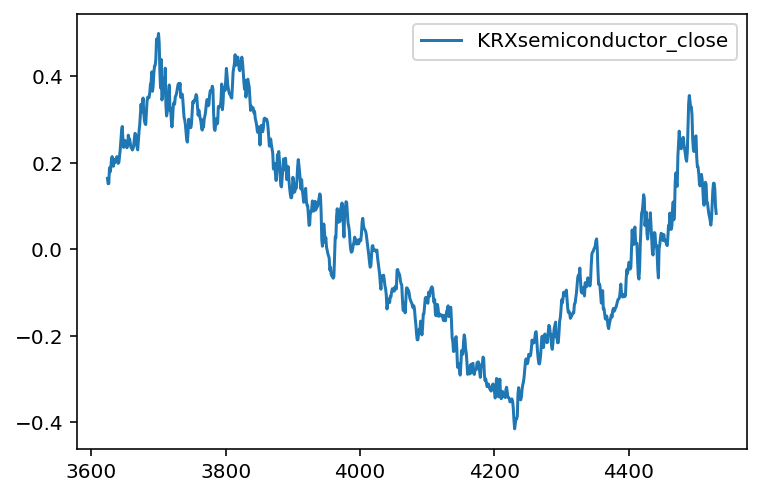

In [70]:
pd.DataFrame(y_test).plot()

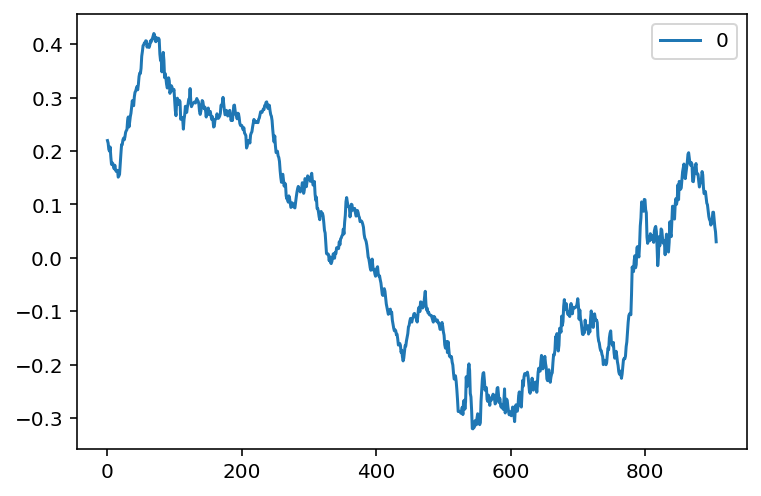

In [71]:
pd.DataFrame(y_pred).plot()

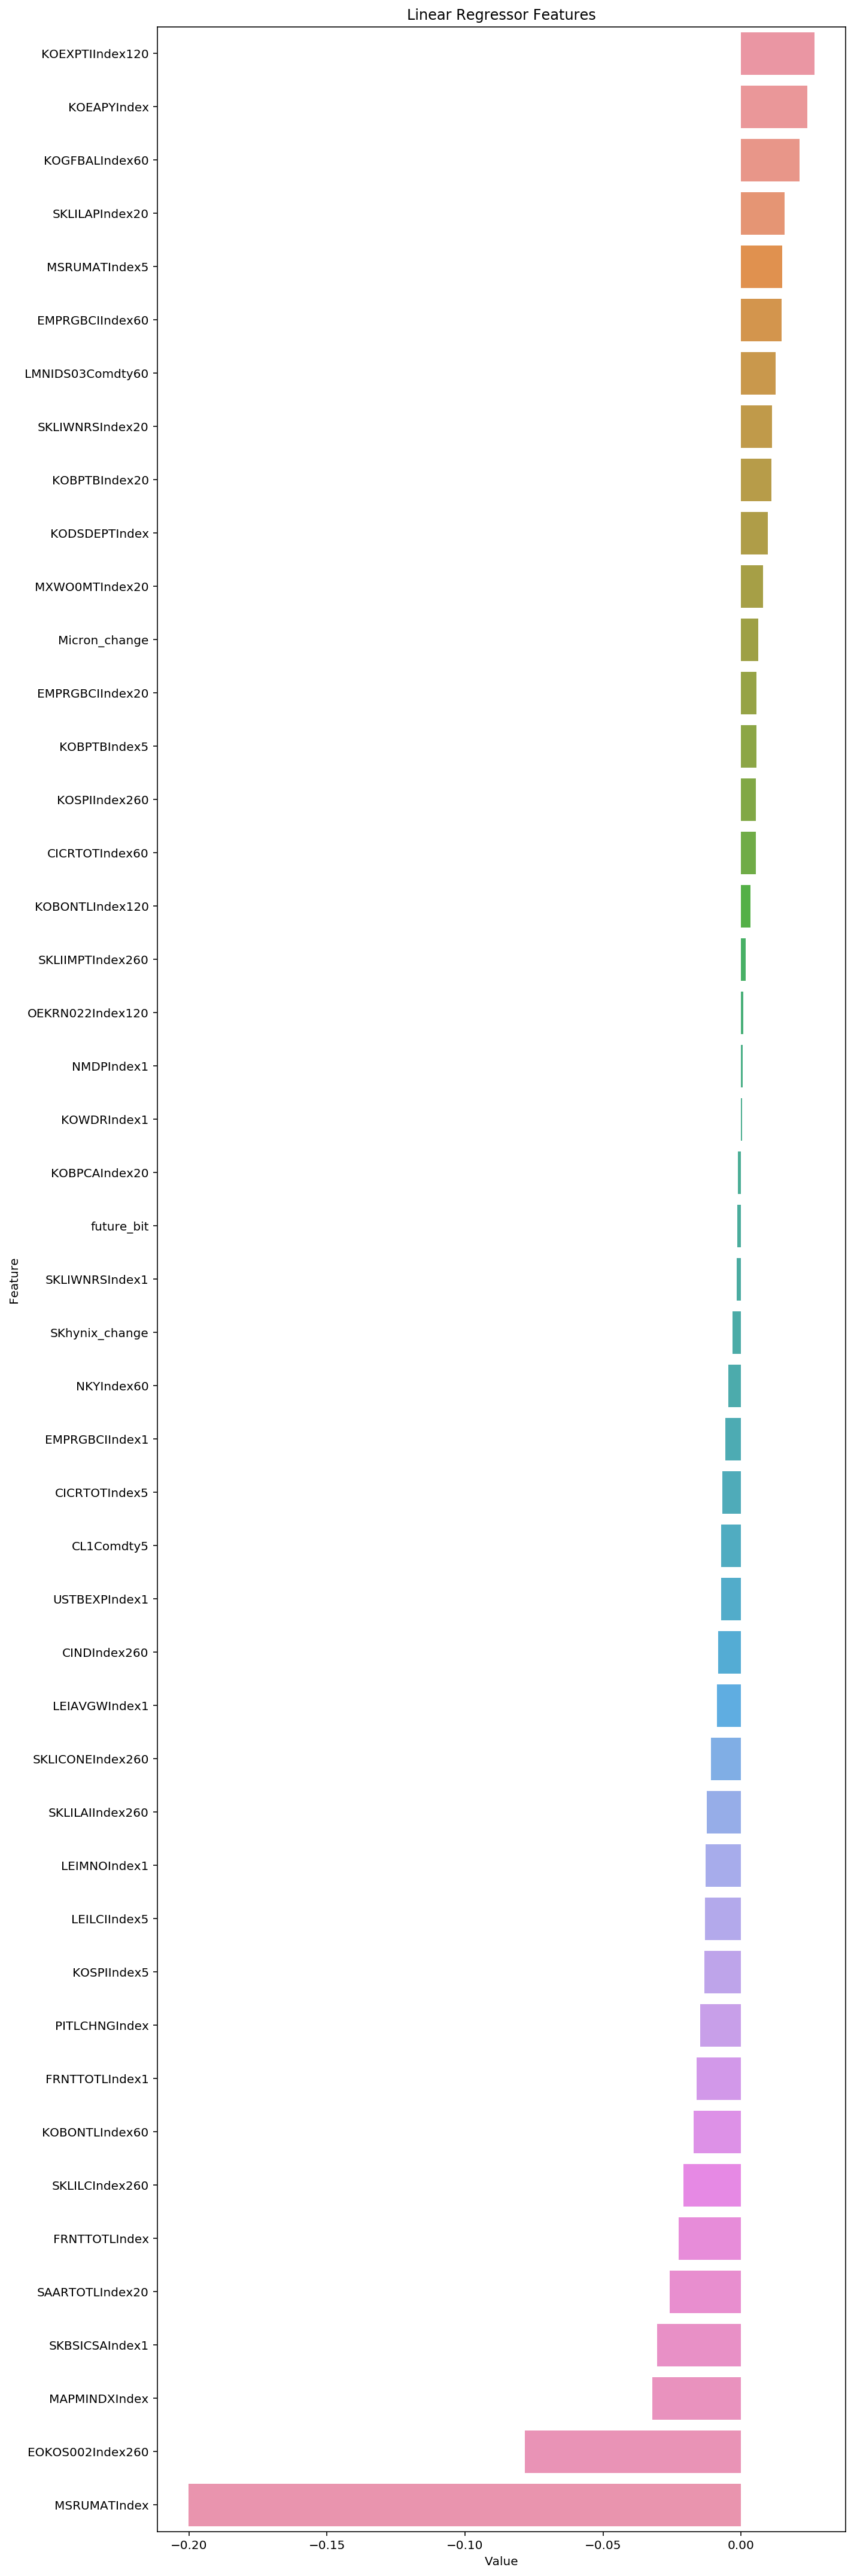

In [73]:
coef_imp = pd.DataFrame(sorted(zip(lr_reg.coef_, X_train.columns)), columns = ['Value', 'Feature'])
coef_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = coef_imp.sort_values(by = 'Value', ascending = False))
plt.title('Linear Regressor Features')
plt.tight_layout()
plt.show()

Tree Model은 feature importance가 따로 뽑히므로 아래와 같이 시각화

# Optuna AutoML을 통한 LightGBM Hyperparameter tuning

In [79]:
import sklearn.ensemble
import sklearn.model_selection
from sklearn.metrics import r2_score
import optuna
import optuna.integration.lightgbm as lgb

In [80]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'regression',
    'metric': 'l2',
    'verbosity': -1,
    'boosting_type': 'gbdt',
}

best_params, tuning_history = dict(), list()

model = lgb.train(params,
                  dtrain,
                  valid_sets=[dtrain, dval],
                  best_params=best_params,
                  tuning_history=tuning_history,
                  verbose_eval=100,
                  early_stopping_rounds=100,
                  )

prediction = np.rint(model.predict(X_test, num_iteration=model.best_iteration))
r2_score = r2_score(y_test, prediction)

print('Number of finished trials: {}'.format(len(tuning_history)))
print('Best params:', best_params)
print('  r2_score = {}'.format(r2_score))
print('  Params: ')
for key, value in best_params.items():
    print('    {}: {}'.format(key, value))

tune_feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000201384	valid_1's l2: 0.0614408
Early stopping, best iteration is:
[1]	training's l2: 0.0610995	valid_1's l2: 0.0521898


tune_feature_fraction, val_score: 0.052190:  14%|#4        | 1/7 [00:00<00:00,  7.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000192091	valid_1's l2: 0.0603032
Early stopping, best iteration is:
[4]	training's l2: 0.0336833	valid_1's l2: 0.0539746


tune_feature_fraction, val_score: 0.052190:  29%|##8       | 2/7 [00:00<00:00,  6.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000180885	valid_1's l2: 0.0571964
Early stopping, best iteration is:
[7]	training's l2: 0.0190608	valid_1's l2: 0.048412


tune_feature_fraction, val_score: 0.048412:  43%|####2     | 3/7 [00:00<00:00,  6.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000181344	valid_1's l2: 0.0514421
Early stopping, best iteration is:
[4]	training's l2: 0.0331331	valid_1's l2: 0.0442798


tune_feature_fraction, val_score: 0.044280:  57%|#####7    | 4/7 [00:00<00:00,  6.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000176455	valid_1's l2: 0.054589
Early stopping, best iteration is:
[6]	training's l2: 0.0225864	valid_1's l2: 0.0491428


tune_feature_fraction, val_score: 0.044280:  71%|#######1  | 5/7 [00:00<00:00,  5.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000174592	valid_1's l2: 0.0572041
Early stopping, best iteration is:
[2]	training's l2: 0.0488645	valid_1's l2: 0.0492388


tune_feature_fraction, val_score: 0.044280:  86%|########5 | 6/7 [00:01<00:00,  5.77it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000176653	valid_1's l2: 0.0551021
Early stopping, best iteration is:
[7]	training's l2: 0.018748	valid_1's l2: 0.0497742


tune_num_leaves, val_score: 0.044280:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000208898	valid_1's l2: 0.0487264
Early stopping, best iteration is:
[9]	training's l2: 0.0132799	valid_1's l2: 0.044175


tune_num_leaves, val_score: 0.044175:   5%|5         | 1/20 [00:00<00:02,  7.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000253914	valid_1's l2: 0.0503588
Early stopping, best iteration is:
[11]	training's l2: 0.00982947	valid_1's l2: 0.0451887


tune_num_leaves, val_score: 0.044175:  10%|#         | 2/20 [00:00<00:02,  6.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.21299e-05	valid_1's l2: 0.0509909
Early stopping, best iteration is:
[4]	training's l2: 0.0319559	valid_1's l2: 0.0454118


tune_num_leaves, val_score: 0.044175:  15%|#5        | 3/20 [00:00<00:04,  4.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0050863	valid_1's l2: 0.0379108
Early stopping, best iteration is:
[22]	training's l2: 0.0158655	valid_1's l2: 0.0334375


tune_num_leaves, val_score: 0.033438:  20%|##        | 4/20 [00:00<00:03,  4.23it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.21299e-05	valid_1's l2: 0.0509909
Early stopping, best iteration is:
[4]	training's l2: 0.0319559	valid_1's l2: 0.0454118


tune_num_leaves, val_score: 0.033438:  25%|##5       | 5/20 [00:01<00:03,  4.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.45217e-05	valid_1's l2: 0.0512622
Early stopping, best iteration is:
[4]	training's l2: 0.031957	valid_1's l2: 0.0454205


tune_num_leaves, val_score: 0.033438:  30%|###       | 6/20 [00:01<00:04,  3.27it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.45217e-05	valid_1's l2: 0.0512622
Early stopping, best iteration is:
[4]	training's l2: 0.031957	valid_1's l2: 0.0454205


tune_num_leaves, val_score: 0.033438:  35%|###5      | 7/20 [00:02<00:04,  2.88it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.21299e-05	valid_1's l2: 0.0509909
Early stopping, best iteration is:
[4]	training's l2: 0.0319559	valid_1's l2: 0.0454118


tune_num_leaves, val_score: 0.033438:  40%|####      | 8/20 [00:02<00:04,  2.65it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.21299e-05	valid_1's l2: 0.0509909
Early stopping, best iteration is:
[4]	training's l2: 0.0319559	valid_1's l2: 0.0454118


tune_num_leaves, val_score: 0.033438:  45%|####5     | 9/20 [00:03<00:04,  2.51it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.29895e-05	valid_1's l2: 0.0512687
Early stopping, best iteration is:
[4]	training's l2: 0.0319559	valid_1's l2: 0.0454185


tune_num_leaves, val_score: 0.033438:  50%|#####     | 10/20 [00:03<00:04,  2.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 4.62674e-05	valid_1's l2: 0.0520335
Early stopping, best iteration is:
[4]	training's l2: 0.0321036	valid_1's l2: 0.0445061


tune_num_leaves, val_score: 0.033438:  55%|#####5    | 11/20 [00:03<00:03,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00326994	valid_1's l2: 0.0414013
Early stopping, best iteration is:
[19]	training's l2: 0.0139965	valid_1's l2: 0.037814


tune_num_leaves, val_score: 0.033438:  60%|######    | 12/20 [00:03<00:03,  2.58it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0050863	valid_1's l2: 0.0379108
Early stopping, best iteration is:
[22]	training's l2: 0.0158655	valid_1's l2: 0.0334375


tune_num_leaves, val_score: 0.033438:  65%|######5   | 13/20 [00:04<00:02,  3.42it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.14972e-05	valid_1's l2: 0.0519634
Early stopping, best iteration is:
[4]	training's l2: 0.0321402	valid_1's l2: 0.0454023


tune_num_leaves, val_score: 0.033438:  70%|#######   | 14/20 [00:04<00:01,  3.36it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 5.45293e-05	valid_1's l2: 0.0527109
Early stopping, best iteration is:
[4]	training's l2: 0.0321547	valid_1's l2: 0.0453158


tune_num_leaves, val_score: 0.033438:  75%|#######5  | 15/20 [00:04<00:01,  3.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00136817	valid_1's l2: 0.0490956
Early stopping, best iteration is:
[9]	training's l2: 0.0206073	valid_1's l2: 0.0421823


tune_num_leaves, val_score: 0.033438:  80%|########  | 16/20 [00:04<00:01,  3.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 8.59868e-05	valid_1's l2: 0.0510502
Early stopping, best iteration is:
[4]	training's l2: 0.0324196	valid_1's l2: 0.0455706


tune_num_leaves, val_score: 0.033438:  85%|########5 | 17/20 [00:05<00:00,  3.71it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 3.46907e-05	valid_1's l2: 0.0525142
Early stopping, best iteration is:
[4]	training's l2: 0.0320003	valid_1's l2: 0.0453841


tune_num_leaves, val_score: 0.033438:  90%|######### | 18/20 [00:05<00:00,  3.07it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.000148917	valid_1's l2: 0.0523936
Early stopping, best iteration is:
[4]	training's l2: 0.0329176	valid_1's l2: 0.0455986


tune_num_leaves, val_score: 0.033438:  95%|#########5| 19/20 [00:05<00:00,  3.45it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00983038	valid_1's l2: 0.0359347
Early stopping, best iteration is:
[33]	training's l2: 0.0181534	valid_1's l2: 0.032999


tune_num_leaves, val_score: 0.032999: 100%|##########| 20/20 [00:05<00:00,  3.48it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.032999:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00973638	valid_1's l2: 0.0364792
Early stopping, best iteration is:
[35]	training's l2: 0.0175539	valid_1's l2: 0.0332988


tune_bagging_fraction_and_bagging_freq, val_score: 0.032999:   0%|          | 0/10 [00:00<?, ?it/s][I 2020-03-19 21:30:44,062] Finished trial#0 resulted in value: 0.03329882437002185. Current best value is 0.03329882437002185 with parameters: {'bagging_fraction': 0.8091736744599931, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032999:  10%|#         | 1/10 [00:00<00:00, 15.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00977606	valid_1's l2: 0.0358954
Early stopping, best iteration is:
[49]	training's l2: 0.0143874	valid_1's l2: 0.0328659


tune_bagging_fraction_and_bagging_freq, val_score: 0.032866:  10%|#         | 1/10 [00:00<00:00, 10.55it/s][I 2020-03-19 21:30:44,130] Finished trial#1 resulted in value: 0.032865942714758914. Current best value is 0.032865942714758914 with parameters: {'bagging_fraction': 0.8933447978163458, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032866:  20%|##        | 2/10 [00:00<00:00, 15.02it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00987476	valid_1's l2: 0.0341224
Early stopping, best iteration is:
[73]	training's l2: 0.0116218	valid_1's l2: 0.0337309


tune_bagging_fraction_and_bagging_freq, val_score: 0.032866:  30%|###       | 3/10 [00:00<00:00, 18.29it/s][I 2020-03-19 21:30:44,200] Finished trial#2 resulted in value: 0.03373090667206642. Current best value is 0.032865942714758914 with parameters: {'bagging_fraction': 0.8933447978163458, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032866:  30%|###       | 3/10 [00:00<00:00, 18.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00956632	valid_1's l2: 0.0339385
Early stopping, best iteration is:
[64]	training's l2: 0.012292	valid_1's l2: 0.0321008


tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  30%|###       | 3/10 [00:00<00:00, 18.29it/s][I 2020-03-19 21:30:44,267] Finished trial#3 resulted in value: 0.03210084574494735. Current best value is 0.03210084574494735 with parameters: {'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  40%|####      | 4/10 [00:00<00:00, 18.29it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00969494	valid_1's l2: 0.0344353
Early stopping, best iteration is:
[39]	training's l2: 0.0164745	valid_1's l2: 0.0332889


tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  50%|#####     | 5/10 [00:00<00:00, 17.46it/s][I 2020-03-19 21:30:44,327] Finished trial#4 resulted in value: 0.0332888622413162. Current best value is 0.03210084574494735 with parameters: {'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  50%|#####     | 5/10 [00:00<00:00, 17.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00970595	valid_1's l2: 0.0362528
Early stopping, best iteration is:
[55]	training's l2: 0.0135356	valid_1's l2: 0.0338515


tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  50%|#####     | 5/10 [00:00<00:00, 17.46it/s][I 2020-03-19 21:30:44,391] Finished trial#5 resulted in value: 0.03385153518611259. Current best value is 0.03210084574494735 with parameters: {'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  60%|######    | 6/10 [00:00<00:00, 17.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00974915	valid_1's l2: 0.035086
Early stopping, best iteration is:
[47]	training's l2: 0.0149518	valid_1's l2: 0.0322374


tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  70%|#######   | 7/10 [00:00<00:00, 16.86it/s][I 2020-03-19 21:30:44,454] Finished trial#6 resulted in value: 0.032237385230485124. Current best value is 0.03210084574494735 with parameters: {'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  70%|#######   | 7/10 [00:00<00:00, 16.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00973161	valid_1's l2: 0.0348271
Early stopping, best iteration is:
[61]	training's l2: 0.0126984	valid_1's l2: 0.0329935


tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  70%|#######   | 7/10 [00:00<00:00, 16.86it/s][I 2020-03-19 21:30:44,520] Finished trial#7 resulted in value: 0.032993497530973304. Current best value is 0.03210084574494735 with parameters: {'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  80%|########  | 8/10 [00:00<00:00, 16.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00980491	valid_1's l2: 0.0357689
Early stopping, best iteration is:
[50]	training's l2: 0.0142492	valid_1's l2: 0.0330881


tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  90%|######### | 9/10 [00:00<00:00, 16.20it/s][I 2020-03-19 21:30:44,587] Finished trial#8 resulted in value: 0.03308807131735979. Current best value is 0.03210084574494735 with parameters: {'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  90%|######### | 9/10 [00:00<00:00, 16.20it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00969135	valid_1's l2: 0.0354595
Early stopping, best iteration is:
[49]	training's l2: 0.0143134	valid_1's l2: 0.0322305


tune_bagging_fraction_and_bagging_freq, val_score: 0.032101:  90%|######### | 9/10 [00:00<00:00, 16.20it/s][I 2020-03-19 21:30:44,648] Finished trial#9 resulted in value: 0.03223054529910867. Current best value is 0.03210084574494735 with parameters: {'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.032101: 100%|##########| 10/10 [00:00<00:00, 15.38it/s]
tune_feature_fraction, val_score: 0.032101:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00957911	valid_1's l2: 0.0346903
Early stopping, best iteration is:
[61]	training's l2: 0.012578	valid_1's l2: 0.0323624


tune_feature_fraction, val_score: 0.032101:  17%|#6        | 1/6 [00:00<00:00, 14.53it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00943635	valid_1's l2: 0.0341959
Early stopping, best iteration is:
[63]	training's l2: 0.0122804	valid_1's l2: 0.0318707


tune_feature_fraction, val_score: 0.031871:  33%|###3      | 2/6 [00:00<00:00, 14.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00948225	valid_1's l2: 0.0343633
Early stopping, best iteration is:
[62]	training's l2: 0.0123662	valid_1's l2: 0.0332019


tune_feature_fraction, val_score: 0.031871:  50%|#####     | 3/6 [00:00<00:00, 18.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00956877	valid_1's l2: 0.0344519
Early stopping, best iteration is:
[64]	training's l2: 0.012299	valid_1's l2: 0.0321642


tune_feature_fraction, val_score: 0.031871:  67%|######6   | 4/6 [00:00<00:00, 18.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00958706	valid_1's l2: 0.0341101
Early stopping, best iteration is:
[65]	training's l2: 0.0121617	valid_1's l2: 0.0324243


tune_feature_fraction, val_score: 0.031871:  83%|########3 | 5/6 [00:00<00:00, 16.83it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_feature_fraction, val_score: 0.031491: 100%|##########| 6/6 [00:00<00:00, 14.69it/s]
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:   0%|          | 0/20 [00:00<?, ?it/s][I 2020-03-19 21:30:45,127] Finished trial#0 resulted in value: 0.03149116835689334. Current best value is 0.03149116835689334 with parameters: {'lambda_l1': 2.44615396667859e-06, 'lambda_l2': 2.6581375651219843e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:   5%|5         | 1/20 [00:00<00:01, 14.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00956614	valid_1's l2: 0.0354663
Early stopping, best iteration is:
[47]	training's l2: 0.0147378	valid_1's l2: 0.031781


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:   5%|5         | 1/20 [00:00<00:01, 10.18it/s][I 2020-03-19 21:30:45,196] Finished trial#1 resulted in value: 0.031780960500739155. Current best value is 0.03149116835689334 with parameters: {'lambda_l1': 2.44615396667859e-06, 'lambda_l2': 2.6581375651219843e-08}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  10%|#         | 2/20 [00:00<00:01, 14.80it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947596	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  15%|#5        | 3/20 [00:00<00:00, 17.44it/s][I 2020-03-19 21:30:45,269] Finished trial#2 resulted in value: 0.03149116554340553. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  15%|#5        | 3/20 [00:00<00:00, 17.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  15%|#5        | 3/20 [00:00<00:00, 17.44it/s][I 2020-03-19 21:30:45,337] Finished trial#3 resulted in value: 0.031491169997182815. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  20%|##        | 4/20 [00:00<00:00, 17.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00956175	valid_1's l2: 0.0350166
Early stopping, best iteration is:
[47]	training's l2: 0.0146131	valid_1's l2: 0.0321293


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  25%|##5       | 5/20 [00:00<00:00, 16.59it/s][I 2020-03-19 21:30:45,405] Finished trial#4 resulted in value: 0.03212933567619915. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  25%|##5       | 5/20 [00:00<00:00, 16.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00980563	valid_1's l2: 0.035485
Early stopping, best iteration is:
[47]	training's l2: 0.0148654	valid_1's l2: 0.0320132


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  25%|##5       | 5/20 [00:00<00:00, 16.59it/s][I 2020-03-19 21:30:45,483] Finished trial#5 resulted in value: 0.03201323322311226. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  30%|###       | 6/20 [00:00<00:00, 16.59it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947603	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147205	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  35%|###5      | 7/20 [00:00<00:00, 15.49it/s][I 2020-03-19 21:30:45,552] Finished trial#6 resulted in value: 0.03149116915722735. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  35%|###5      | 7/20 [00:00<00:00, 15.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.009476	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  35%|###5      | 7/20 [00:00<00:00, 15.49it/s][I 2020-03-19 21:30:45,624] Finished trial#7 resulted in value: 0.03149118614962453. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  40%|####      | 8/20 [00:00<00:00, 15.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0094833	valid_1's l2: 0.0339777
Early stopping, best iteration is:
[47]	training's l2: 0.0147279	valid_1's l2: 0.0314934


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  45%|####5     | 9/20 [00:00<00:00, 14.94it/s][I 2020-03-19 21:30:45,699] Finished trial#8 resulted in value: 0.0314933940711084. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  45%|####5     | 9/20 [00:00<00:00, 14.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00961481	valid_1's l2: 0.0344748
Early stopping, best iteration is:
[64]	training's l2: 0.0123243	valid_1's l2: 0.032376


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  45%|####5     | 9/20 [00:00<00:00, 14.94it/s][I 2020-03-19 21:30:45,770] Finished trial#9 resulted in value: 0.03237596631623041. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  50%|#####     | 10/20 [00:00<00:00, 14.94it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  55%|#####5    | 11/20 [00:00<00:00, 14.40it/s][I 2020-03-19 21:30:45,851] Finished trial#10 resulted in value: 0.031491168122590604. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  55%|#####5    | 11/20 [00:00<00:00, 14.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  55%|#####5    | 11/20 [00:00<00:00, 14.40it/s][I 2020-03-19 21:30:45,928] Finished trial#11 resulted in value: 0.03149116812296519. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  60%|######    | 12/20 [00:00<00:00, 14.40it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  65%|######5   | 13/20 [00:00<00:00, 14.06it/s][I 2020-03-19 21:30:45,998] Finished trial#12 resulted in value: 0.03149116809418187. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  65%|######5   | 13/20 [00:00<00:00, 14.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  65%|######5   | 13/20 [00:00<00:00, 14.06it/s][I 2020-03-19 21:30:46,073] Finished trial#13 resulted in value: 0.031491168102311555. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  70%|#######   | 14/20 [00:01<00:00, 14.06it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  75%|#######5  | 15/20 [00:01<00:00, 13.91it/s][I 2020-03-19 21:30:46,146] Finished trial#14 resulted in value: 0.03149116815555489. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  75%|#######5  | 15/20 [00:01<00:00, 13.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947595	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147204	valid_1's l2: 0.0314912


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  75%|#######5  | 15/20 [00:01<00:00, 13.91it/s][I 2020-03-19 21:30:46,213] Finished trial#15 resulted in value: 0.03149116793474182. Current best value is 0.03149116554340553 with parameters: {'lambda_l1': 2.523014146594942e-06, 'lambda_l2': 0.00044905705814703097}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  80%|########  | 16/20 [00:01<00:00, 13.91it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947605	valid_1's l2: 0.0339775
Early stopping, best iteration is:
[47]	training's l2: 0.0147206	valid_1's l2: 0.0314911


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  85%|########5 | 17/20 [00:01<00:00, 13.99it/s][I 2020-03-19 21:30:46,288] Finished trial#16 resulted in value: 0.031491138673328735. Current best value is 0.031491138673328735 with parameters: {'lambda_l1': 6.933975769970744e-06, 'lambda_l2': 0.004796207071351173}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  85%|########5 | 17/20 [00:01<00:00, 13.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947766	valid_1's l2: 0.0339773
Early stopping, best iteration is:
[47]	training's l2: 0.014724	valid_1's l2: 0.0314907


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  85%|########5 | 17/20 [00:01<00:00, 13.99it/s][I 2020-03-19 21:30:46,358] Finished trial#17 resulted in value: 0.031490676535346214. Current best value is 0.031490676535346214 with parameters: {'lambda_l1': 8.84012105100178e-06, 'lambda_l2': 0.07866522228484679}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  90%|######### | 18/20 [00:01<00:00, 13.99it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947773	valid_1's l2: 0.0339774
Early stopping, best iteration is:
[47]	training's l2: 0.0147237	valid_1's l2: 0.0314909


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  95%|#########5| 19/20 [00:01<00:00, 14.00it/s][I 2020-03-19 21:30:46,430] Finished trial#18 resulted in value: 0.0314908782004276. Current best value is 0.031490676535346214 with parameters: {'lambda_l1': 8.84012105100178e-06, 'lambda_l2': 0.07866522228484679}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  95%|#########5| 19/20 [00:01<00:00, 14.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00990271	valid_1's l2: 0.0352326
Early stopping, best iteration is:
[47]	training's l2: 0.0151557	valid_1's l2: 0.0324856


tune_lambda_l1_and_lambda_l2, val_score: 0.031491:  95%|#########5| 19/20 [00:01<00:00, 14.00it/s][I 2020-03-19 21:30:46,497] Finished trial#19 resulted in value: 0.03248556409842353. Current best value is 0.031490676535346214 with parameters: {'lambda_l1': 8.84012105100178e-06, 'lambda_l2': 0.07866522228484679}.
tune_lambda_l1_and_lambda_l2, val_score: 0.031491: 100%|##########| 20/20 [00:01<00:00, 13.92it/s]
tune_min_child_samples, val_score: 0.031491:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947766	valid_1's l2: 0.0339773
Early stopping, best iteration is:
[47]	training's l2: 0.014724	valid_1's l2: 0.0314907


tune_min_child_samples, val_score: 0.031491:  20%|##        | 1/5 [00:00<00:00, 15.43it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947766	valid_1's l2: 0.0339773
Early stopping, best iteration is:
[47]	training's l2: 0.014724	valid_1's l2: 0.0314907


tune_min_child_samples, val_score: 0.031491:  40%|####      | 2/5 [00:00<00:00, 15.48it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00947766	valid_1's l2: 0.0339773
Early stopping, best iteration is:
[47]	training's l2: 0.014724	valid_1's l2: 0.0314907


tune_min_child_samples, val_score: 0.031491:  60%|######    | 3/5 [00:00<00:00, 18.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.00976875	valid_1's l2: 0.0340729
Early stopping, best iteration is:
[65]	training's l2: 0.0123522	valid_1's l2: 0.0317338


tune_min_child_samples, val_score: 0.031491:  80%|########  | 4/5 [00:00<00:00, 18.62it/s]

Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.0105759	valid_1's l2: 0.0338345
Early stopping, best iteration is:
[49]	training's l2: 0.015141	valid_1's l2: 0.0315682


tune_min_child_samples, val_score: 0.031491: 100%|##########| 5/5 [00:00<00:00, 14.87it/s]


Number of finished trials: 68
Best params: {'lambda_l1': 8.84012105100178e-06, 'lambda_l2': 0.07866522228484679, 'num_leaves': 2, 'feature_fraction': 0.7799999999999999, 'bagging_fraction': 0.5994877130883713, 'bagging_freq': 1, 'min_child_samples': 20}
  r2_score = -0.0338107080938046
  Params: 
    lambda_l1: 8.84012105100178e-06
    lambda_l2: 0.07866522228484679
    num_leaves: 2
    feature_fraction: 0.7799999999999999
    bagging_fraction: 0.5994877130883713
    bagging_freq: 1
    min_child_samples: 20


### Tuning된 값 입력하여 모델 선언

In [81]:
lgb_reg = LGBMRegressor(lambda_l1 = 8.84012105100178e-06, lambda_l2 = 0.07866522228484679, num_leaves = 2, feature_fraction = 0.7799999999999999, bagging_fraction = 0.5994877130883713, bagging_freq = 1, min_child_samples = 20)

In [82]:
lgb_reg.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.5994877130883713, bagging_freq=1,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.7799999999999999, importance_type='split',
              lambda_l1=8.84012105100178e-06, lambda_l2=0.07866522228484679,
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=2, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [83]:
lgb_pred = lgb_reg.predict(X_test)

In [84]:
lgb_pred

array([ 1.46180318e-01,  1.36691419e-01,  1.04688207e-01,  1.12765338e-01,
        1.36691419e-01,  1.04688207e-01,  1.04688207e-01,  1.04338851e-01,
        1.28264932e-01,  1.28264932e-01,  1.37753831e-01,  1.37753831e-01,
        1.28264932e-01,  1.28264932e-01,  1.28264932e-01,  1.28264932e-01,
        1.04338851e-01,  9.62617196e-02,  1.00350794e-01,  1.37753831e-01,
        1.37753831e-01,  1.37753831e-01,  1.37753831e-01,  1.37753831e-01,
        1.37753831e-01,  1.37753831e-01,  1.37753831e-01,  1.37753831e-01,
        1.37753831e-01,  1.37753831e-01,  1.37753831e-01,  1.37753831e-01,
        9.62617196e-02,  1.01317526e-01,  1.01317526e-01,  1.01317526e-01,
        1.09394658e-01,  1.33320739e-01,  1.01317526e-01,  1.01317526e-01,
        8.54680800e-02,  8.54680800e-02,  8.54680800e-02,  8.54680800e-02,
        8.54680800e-02,  8.54680800e-02,  8.54680800e-02,  1.01317526e-01,
        8.54680800e-02,  8.54680800e-02,  8.54680800e-02,  1.01317526e-01,
        1.09394658e-01,  

In [85]:
y_test = np.array(y_test)

In [88]:
metr = CustomMetric(lgb_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.587832,0.3190,0.1603,0.1843,0.732084,0.903084


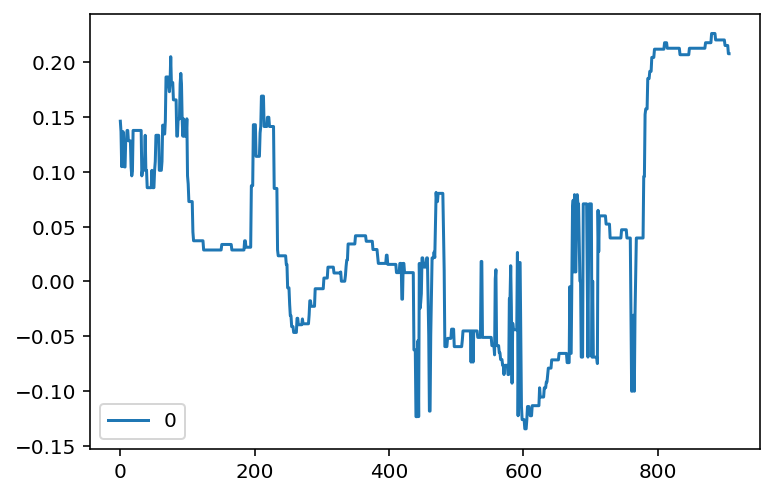

In [89]:
pd.DataFrame(lgb_pred).plot()

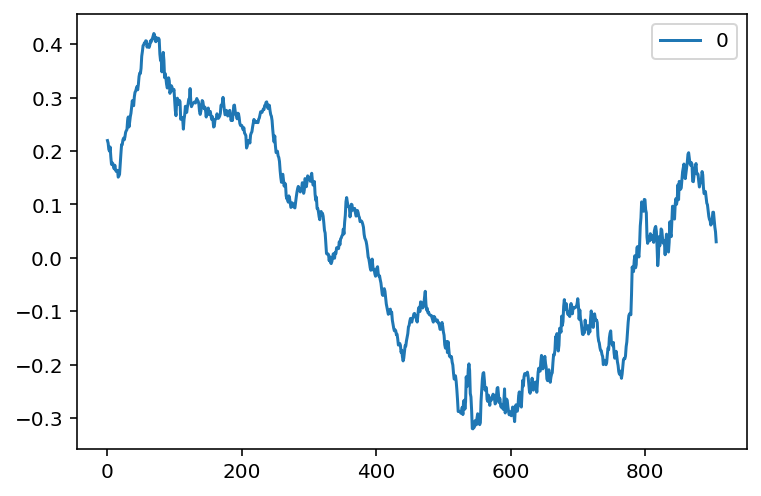

In [90]:
pd.DataFrame(y_pred).plot()

In [87]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

In [ ]:
feat_imp = pd.DataFrame(sorted(zip(lgb_reg.feature_importances_, X_train.columns)), columns = ['Value', 'Feature'])
feat_imp.sort_values(by = 'Value', ascending = False)
plt.figure(figsize = (10, 30))
sns.barplot(x = 'Value', y = 'Feature', data = feat_imp.sort_values(by = 'Value', ascending = False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('lgbm_importances_1.png')
plt.show()